voxels.shape: (8, 8, 8)
voxels[1, 1, 1]: False
voxels[4, 4, 4]: True
colors.shape: (8, 8, 8)
colors[1, 1, 1]: None
colors[4, 4, 4]: blue


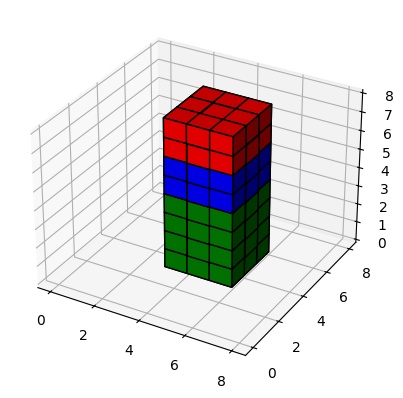

In [1]:
# * from 3d artefacts code: https://github.com/real-itu/3d-artefacts-nca/blob/master/notebooks/CustomVoxel.ipynb

import matplotlib.pyplot as plt
import numpy as np

# prepare some coordinates
x, y, z = np.indices((8, 8, 8))

# draw cuboids in the top left and bottom right corners, and a link between them
cube1 = (x <= 5) & (x >= 3) & (y <= 5) & (y >= 3) & (z < 4)
cube2 = (x <= 5) & (x >= 3) & (y <= 5) & (y >= 3) & (z >= 4) & (z < 6)
cube3 = (x <= 5) & (x >= 3) & (y <= 5) & (y >= 3) & (z >= 6) & (z < 8) 

# link = abs(x - y) + abs(y - z) + abs(z - x) <= 2

# combine the objects into a single boolean array
voxels = cube1 | cube2 | cube3
print ('voxels.shape:',voxels.shape)
print ('voxels[1, 1, 1]:',voxels[1, 1, 1])
print ('voxels[4, 4, 4]:',voxels[4, 4, 4])

# set the colors of each object
colors = np.empty(voxels.shape, dtype=object)
colors[cube3] = 'red'
colors[cube1] = 'green'
colors[cube2] = 'blue'

# and plot everything
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

print ('colors.shape:',colors.shape)
print ('colors[1, 1, 1]:',colors[1, 1, 1])
print ('colors[4, 4, 4]:',colors[4, 4, 4])
ax.voxels(colors, facecolors=colors, edgecolor='k')

plt.show()

rc.shape: (16, 16, 16)
sphere.shape: (16, 16, 16)
colors.shape: (16, 16, 16, 3)


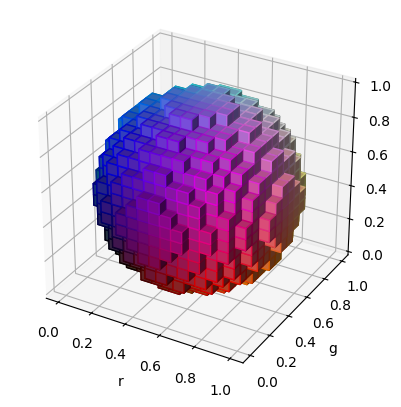

In [2]:
# * from example code: https://matplotlib.org/stable/gallery/mplot3d/voxels_rgb.html

def midpoints(x):
    sl = ()
    for _ in range(x.ndim):
        x = (x[sl + np.index_exp[:-1]] + x[sl + np.index_exp[1:]]) / 2.0
        sl += np.index_exp[:]
    return x

# prepare some coordinates, and attach rgb values to each
r, g, b = np.indices((17, 17, 17)) / 16.0
rc = midpoints(r)
gc = midpoints(g)
bc = midpoints(b)

print ('rc.shape:',rc.shape)

# define a sphere about [0.5, 0.5, 0.5]
sphere = (rc - 0.5)**2 + (gc - 0.5)**2 + (bc - 0.5)**2 < 0.5**2
print ('sphere.shape:',sphere.shape)

# combine the color components
colors = np.zeros(sphere.shape + (3,))
colors[..., 0] = rc
colors[..., 1] = gc
colors[..., 2] = bc
print ('colors.shape:',colors.shape)

# and plot everything
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(r, g, b, sphere,
          facecolors=colors,
          edgecolors=np.clip(2*colors - 0.5, 0, 1),  # brighter
          linewidth=1)
ax.set(xlabel='r', ylabel='g', zlabel='b')
ax.set_aspect('equal')

plt.show()

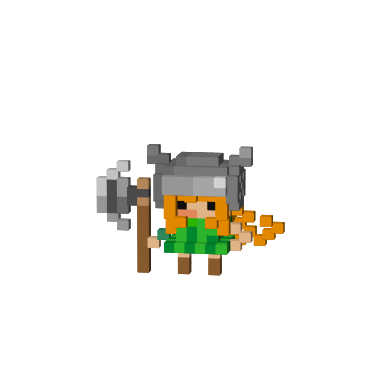

In [4]:
from Vox import Vox
from VoxelNCA import create_seed

_3x3x3 = Vox().load_from_file('_vox_files/3x3x3.vox')
knight = Vox().load_from_file('_vox_files/knight.vox')
# burger = Vox.load_from_file('_vox_files/burger.vox')
# trex = Vox.load_from_file('_vox_files/t_rex.vox')

knight.render()
_3x3x3.orbit('_videos/3x3x3.mp4', _delta=5)

seed = np.array(create_seed(_dist=3, _points=4))
seed_vox = Vox().load_from_array(seed)
seed_vox.orbit('_videos/seed.mp4', _delta=5, _show_grid=True)